In [8]:
##################################################  
##  AUTHOR: ARTHUR KALINOWSKI
##################################################  
import tensorflow as tf
import random
import pathlib
import glob
import time
import numpy as np
import ROOT
import pandas as pd
from root_pandas import read_root
from root_numpy import root2array
import root_numpy
import root_pandas 
import math
import tensorflow.keras.backend as keras_backend
import seaborn as sns
from termcolor import colored
import scipy
import matplotlib.pyplot as plt
from matplotlib import colors
import pyarrow.fs as fs


#for version compatibility check
print("ROOT version: ", ROOT.__version__)
print("NumPy version: ", np.__version__)
print("TensorFlow version: ", tf.__version__)
print("Pandas version: ", pd.__version__)
print("root numpy version: ", root_numpy.__version__)
print("root pnadas version: ", root_pandas.__version__)




#Training sample doFilter = True , for test samples False
#Not neccessarily to be here , for an immediate check on the test parquet sample 
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)
fileSystem = fs.LocalFileSystem()
nLayers = 18
namestring = 'SingleMu_OneOverPt_Feb15'
ntuple_url = '/scratch_cmsse/alibordi/MachineLearning/alibordi/ntuple_for_TFRec/April_Samples'
ntuple_url_feb = '/scratch_cmsse/alibordi/MachineLearning/alibordi/ntuple_for_TFRec/February_Samples'

ROOT version:  6.24/04
NumPy version:  1.20.1
TensorFlow version:  2.7.0
Pandas version:  1.2.5
root numpy version:  4.8.0
root pnadas version:  0.7.0


## Definitions of functions used in this notebook.

In [9]:
columns = np.array(['muonPt', 'muonEta', 'muonPhi', 'muonCharge', 'omtfPt', 'omtfEta',
       'omtfPhi', 'omtfCharge', 'omtfScore', 'omtfQuality', 'omtfRefLayer',
       'omtfProcessor', 'omtfFiredLayers', 'phiDist_0', 'phiDist_1',
       'phiDist_2', 'phiDist_3', 'phiDist_4', 'phiDist_5', 'phiDist_6',
       'phiDist_7', 'phiDist_8', 'phiDist_9', 'phiDist_10', 'phiDist_11',
       'phiDist_12', 'phiDist_13', 'phiDist_14', 'phiDist_15', 'phiDist_16',
       'phiDist_17','eventNum','muonEvent','muonDxy', 'muonRho','omtfHwEta','omtfRefHitNum'])



def decodeUnion(raw, unionFormat):     
    rawData = int(raw)
    layer    = rawData &               0xff 
    quality = (rawData &             0xff00) >> 8
    z       = (rawData &           0xff0000) >> 16 
    eta   = 0
    valid = 1
    phiDist = 0     
    if unionFormat=="new":
        valid   = (rawData &         0xff000000) >> 24
        eta     = (rawData &     0xffff00000000) >> 32
        phiDist = (rawData & 0xffff000000000000) >> 48
    else:
        eta   = (rawData &         0xff000000) >> 24
        phiDist     = (rawData &     0xffff00000000) >> 32 
    if phiDist>=2**15 -1:
        phiDist -= 2**16
    return np.array([layer, quality, z, valid, eta, phiDist], dtype='int16')

def decodeHits(hits, unionFormat):
    phiDistArray = np.full(nLayers, 9999, dtype='int16')
    for aHit in hits:
        decodedUnion = decodeUnion(aHit, unionFormat)
        np.put(phiDistArray, decodedUnion[0], decodedUnion[5])    
    return phiDistArray  

def transformColumns(df, unionFormat):
    df["omtfFiredLayers"] = df["omtfFiredLayers"].transform(lambda x: np.binary_repr(x,18).count("1"))
    columnNames = ["phiDist_{}".format(iLayer) for iLayer in range(0, nLayers)]                         
    for iLayer in range(0, nLayers):
            df["phiDist_{}".format(iLayer)] = df["hits"].transform(lambda x: decodeHits(x, unionFormat)[iLayer]).astype('int16',copy=False)

def loadDatasetFromParquet(parquetFile):
    df = pd.read_parquet(parquetFile)
    df = df.drop(columns="hits")
    df = df.drop(columns="killed")
    df = df.sample(frac=1.0)
    df.info(memory_usage='deep')
    dataset = tf.data.Dataset.from_tensor_slices(df.values)
    return dataset

def saveDatasetToTFRecord(dataset, fileName):  
    dataset = dataset.map(lambda x: tf.cast(x, tf.float32))
    dataset = dataset.map(tf.io.serialize_tensor)
    writer = tf.data.experimental.TFRecordWriter(fileName, compression_type="GZIP")
    writer.write(dataset)
    
def parse_tensor(tensor):
    return tf.io.parse_tensor(tensor, out_type=tf.float32)  

def benchmark(dataset, num_epochs=1):
    start_time = time.perf_counter()
    count = 0
    for epoch_num in range(num_epochs):
        for sample in dataset:
            count+=sample.shape[0]
            time.sleep(1E-10)
    tf.print("Number of examples: ",count)       
    tf.print("Execution time:", time.perf_counter() - start_time) 
    
def convertROOT_2_Parquet_2_TFRecord(fileNames):
    for fileName in fileNames: 
        print("Processing file:",fileName)
        label = fileName.split("/")[-1].split(".")[0]
        label = label.lstrip(namestring)
        path = str(pathlib.Path(fileName).parent)
        path = path.rstrip(namestring)
        path = path.replace("ROOT","Python/")
        for iChunk, dfChunk in enumerate(read_root(fileName, chunksize=int(15E6))):
            print("\tProcessing chunk: {}".format(iChunk))
            transformColumns(dfChunk, unionFormat="new")   
            parquetFile = 'data_II/df.parquet_'+namestring+'_{}_chunk_{}.gzip'.format(label, iChunk)
            dfChunk["killed"] = dfChunk["killed"].astype('int16')
            for col in dfChunk.columns:
                col_type = dfChunk.dtypes.get(col).name
                if col_type == 'int8':
                    dfChunk[col] = dfChunk[col].astype('int16')
            dfChunk.to_parquet(parquetFile, compression='gzip')
            dataset = loadDatasetFromParquet(parquetFile)
            dataset = dataset.map(tf.io.serialize_tensor)
            print(dataset)
            tfrecordFileName = 'data_II/Muon_{}_'+namestring+'_chunk_{}.tfrecord.gzip'.format(label,iChunk)
            writer = tf.data.experimental.TFRecordWriter(tfrecordFileName, compression_type="GZIP")
            writer.write(dataset)
            print("Chunk done.")
            break
        print("File done.")
     
    
    
def convertParquet_2_TFRecord(fileNames, isTrain, doFilter):
    for parquetFile in fileNames: 
        print("Processing file:",parquetFile)
        label = parquetFile.split("/")[-1]
        label = label.lstrip(namestring+'df.parquet_')
        label = label.rstrip(".gzip")
        path = str(pathlib.Path(parquetFile).parent)+"/"
        dataset = loadDatasetFromParquet(parquetFile)
        if doFilter:
            print("Filtering.")
            dataset = filterDataset(dataset, isTrain)
            label = label+"_filtered"
            path = path+"/filtered/"
        tfrecordFileName = path+label+'.tfrecord.gzip'
        print("Saving to TFRecord file.")
        saveDatasetToTFRecord(dataset, tfrecordFileName) 
        print("File done.")
        
def test(fileNames, isTrain, doFilter):
    parquetFile = fileNames[0]
    label = parquetFile.split("/")[-1]
    label = label.lstrip(namestring+'vdf.parquet_')
    label = label.rstrip(".gzip")
    path = str(pathlib.Path(parquetFile).parent)+"/"
    if doFilter:
        label = label+"_filtered"
        path = path+"/filtered/"
    tfrecordFileName = path+'{}.tfrecord_TEST.gzip'.format(label)
    writer = tf.data.experimental.TFRecordWriter(tfrecordFileName, compression_type="GZIP")
       
    for parquetFile in fileNames: 
        print("Processing file:",parquetFile)
        print("Loading parquet file.")
        dataset = loadDatasetFromParquet(parquetFile).take(10)
        if doFilter:
            print("Filtering.")
            dataset = filterDataset(dataset, isTrain)       
        tfrecordFileName = path+label+'.tfrecord.gzip'
        print("Saving to TFRecord file.")
        saveDatasetToTFRecord(dataset, tfrecordFileName)    
        print("File done.")        
        
                
def filterDataset(dataset, isTrain):      
    dataset = dataset.filter(lambda x: x[columnIndex]>0.01)  
    columnIndex = np.where(columns == "omtfPt")[0][0]
    dataset = dataset.filter(lambda x: x[columnIndex]>0.01)
    
    if isTrain:
        #Select muon basing on generated pT
        columnIndex = np.where(columns == "muonPt")[0][0]
        dataset = dataset.filter(lambda x: x[columnIndex]<100)  
    return dataset       

##  Import ROOT files into Pandas DataFrame, and save into a parquet format, then transform into TFRecord
This step should be executed only once. Later the data should be read from parquet or TFRecord files.

In [10]:
fileNames = glob.glob(ntuple_url_feb+'/SingleMu_interleaved_OneOverPt_SampleFeb15.root')
print(colored("Inpus files:","blue"),fileNames)
convertROOT_2_Parquet_2_TFRecord(fileNames)        

/usr/local/lib64/python3.9/site-packages/root_numpy/_tree.py:234: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  arr = _librootnumpy.root2array_fromfile(


Inpus files: ['/scratch_cmsse/alibordi/MachineLearning/alibordi/ntuple_for_TFRec/February_Samples/SingleMu_interleaved_OneOverPt_SampleFeb15.root']
Processing file: /scratch_cmsse/alibordi/MachineLearning/alibordi/ntuple_for_TFRec/February_Samples/SingleMu_interleaved_OneOverPt_SampleFeb15.root
	Processing chunk: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 277572 entries, 43884 to 92565
Data columns (total 37 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   eventNum         277572 non-null  int64  
 1   muonEvent        277572 non-null  int16  
 2   muonPt           277572 non-null  float32
 3   muonEta          277572 non-null  float32
 4   muonPhi          277572 non-null  float32
 5   muonCharge       277572 non-null  int16  
 6   muonDxy          277572 non-null  float32
 7   muonRho          277572 non-null  float32
 8   omtfPt           277572 non-null  float32
 9   omtfEta          277572 non-null  float32
 10  

## Write TFRecord from parquet files : Step 1. I am concatenating the parquets and filtering those within the omtf $0.83< |\eta| < 1.24$ range and also kepping only the transverse momentum values greater than the $p_T > 0$ for both gen muons and OMTF candidates , Step 2. Sanity check of the produced merged file will be used for training, Step 3. Conver parquet to TF record.  ( But then as soon as possible things need to be upgraded to Uproot: since the nearest alternate to root_pandas is the Uproot). 

In [11]:
url = 'data_II/df.parquet_SingleMu_OneOverPt_Feb15_aved_OneOverPt_SampleFeb15_chunk_0.gzip'
fileNames = glob.glob(url)
print(colored("Inpus files:","blue"),fileNames)
df_fragments = [pd.read_parquet(fileName) for fileName in fileNames]
df = pd.concat(df_fragments)
#print(df.describe())
# the sample should be filtered only in case of training samples 
df_filtered = df.loc[(np.abs(df['muonEta'])>0.83) & (np.abs(df['muonEta'])<1.24) & (df['muonPt'] > 0.0) & (df['omtfPt'] > 0.00)]
print(df_filtered.describe())
df_filtered.to_parquet('data_II/df.parquet_SingleMu_OneOverPt_Feb15_chunk_0.gzip',compression='gzip')
#df.to_parquet('data_II/df.parquet_SingleMu_OneOverPt_15FebSample.gzip',compression='gzip')

Inpus files: ['data_II/df.parquet_SingleMu_OneOverPt_Feb15_aved_OneOverPt_SampleFeb15_chunk_0.gzip']
            eventNum  muonEvent         muonPt        muonEta        muonPhi  \
count  179145.000000   179145.0  179145.000000  179145.000000  179145.000000   
mean   409931.330481        0.0      29.142008      -0.003787      -0.000760   
std    227949.636982        0.0      25.725769       1.038139       1.813771   
min         1.000000        0.0       3.104555      -1.240000      -3.141590   
25%    218434.000000        0.0       8.381667      -1.031074      -1.577281   
50%    413342.000000        0.0      19.174215      -0.831575      -0.003873   
75%    606422.000000        0.0      43.826885       1.029713       1.569555   
max    800000.000000        0.0      99.998940       1.239999       3.141577   

          muonCharge   muonDxy   muonRho         omtfPt        omtfEta  ...  \
count  179145.000000  179145.0  179145.0  179145.000000  179145.000000  ...   
mean       -0.013537

Inpus files: ['data_II/df.parquet_SingleMu_OneOverPt_Feb15_chunk_0.gzip']


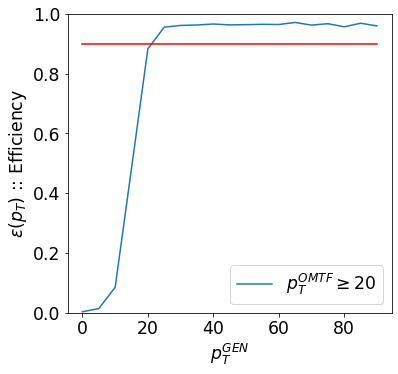

In [12]:
#fileName = glob.glob('data_II/df.filtered_training_22FebSample_Merged_EntirePtRange.gzip')
fileName = glob.glob('data_II/df.parquet_SingleMu_OneOverPt_Feb15_chunk_0.gzip')
print(colored("Inpus files:","blue"),fileName)
#df_filtered = pd.read_parquet(fileName, filesystem=fileSystem)
df = pd.read_parquet(fileName, filesystem=fileSystem)

fig, axes = plt.subplots(1, 1, figsize = (5, 5))
bins = np.arange(0, 100, 5)
#h_denom, _, _ = axes.hist(df_filtered['muonPt'], bins=bins); # for tarining sample
h_denom, _, _ = axes.hist(df['muonPt'], bins=bins);
df_omtf = df[df['omtfPt']>=20] 
df_omtf = df_omtf[df_omtf['omtfQuality']>=12] 
h_num, _, _ = axes.hist(df_omtf['muonPt'], bins=bins);


axes.clear()

eff = h_num/h_denom
x = bins[:-1]
axes.plot(x, eff, label=r'$p_{T}^{OMTF} \geq 20$')
axes.plot([0,90], [0.9,0.9], "r")
axes.set_xlabel(r'$p_{T}^{GEN}$')
axes.set_ylabel(r'$\epsilon(p_{T}$) :: Efficiency')
axes.set_ylim([0,1])
axes.legend()

plt.subplots_adjust(bottom=0.05, left=0.05, right=0.95, wspace=0.3, hspace=0.3)
plt.savefig('data_II/Efficiency' + namestring + '_.png')

In [13]:
fileNames = glob.glob('data_II/df.parquet_SingleMu_OneOverPt_Feb15_chunk_0.gzip')
print(fileNames)
convertParquet_2_TFRecord(fileNames, isTrain = False, doFilter = False)       
#test(fileNames, isTrain = False, doFilter = True)  

['data_II/df.parquet_SingleMu_OneOverPt_Feb15_chunk_0.gzip']
Processing file: data_II/df.parquet_SingleMu_OneOverPt_Feb15_chunk_0.gzip
<class 'pandas.core.frame.DataFrame'>
Int64Index: 179145 entries, 193979 to 167310
Data columns (total 37 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   eventNum         179145 non-null  int64  
 1   muonEvent        179145 non-null  int16  
 2   muonPt           179145 non-null  float32
 3   muonEta          179145 non-null  float32
 4   muonPhi          179145 non-null  float32
 5   muonCharge       179145 non-null  int16  
 6   muonDxy          179145 non-null  float32
 7   muonRho          179145 non-null  float32
 8   omtfPt           179145 non-null  float32
 9   omtfEta          179145 non-null  float32
 10  omtfPhi          179145 non-null  float32
 11  omtfCharge       179145 non-null  int16  
 12  omtfHwEta        179145 non-null  int16  
 13  omtfProcessor    179145 non-null  int16

## Test: read Pandas df from parquet file.

## Test: read TFRecord from TFRecord file.

In [14]:
fileNames = glob.glob('data_II/chunk_0.tfrecord.gzip')
raw_dataset = tf.data.TFRecordDataset(fileNames, compression_type="GZIP")
dataset = raw_dataset.map(parse_tensor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(1000, drop_remainder=False)

#benchmark(raw_dataset.map(parse_tensor,num_parallel_calls=tf.data.experimental.AUTOTUNE))
#benchmark(raw_dataset.map(parse_tensor))
benchmark(dataset)
#benchmark(dataset.prefetch(tf.data.experimental.AUTOTUNE))
#benchmark(tf.data.Dataset.range(2).interleave(dataset))
print(dataset)

for element in dataset.take(1): 
    print(element)
    

Number of examples:  179145
Execution time: 1.5722690700204112
<BatchDataset shapes: <unknown>, types: tf.float32>
tf.Tensor(
[[ 9.0765000e+04  0.0000000e+00  2.6702150e+01 ... -5.0000000e+00
  -1.0000000e+01  9.9990000e+03]
 [ 3.1706000e+04  0.0000000e+00  8.2085365e+01 ...  9.9990000e+03
   9.9990000e+03  9.9990000e+03]
 [ 4.2234000e+04  0.0000000e+00  9.1435947e+00 ...  9.9990000e+03
   9.9990000e+03  9.9990000e+03]
 ...
 [ 6.7313000e+04  0.0000000e+00  1.7878620e+01 ...  9.9990000e+03
  -7.0000000e+00 -1.1000000e+01]
 [ 8.4425000e+04  0.0000000e+00  6.5305672e+00 ...  9.9990000e+03
   2.3000000e+01  2.6000000e+01]
 [ 6.8613600e+05  0.0000000e+00  7.1417770e+01 ...  9.9990000e+03
  -2.0000000e+00 -4.0000000e+00]], shape=(1000, 37), dtype=float32)
